In [81]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error
# from google.colab import drive
import os
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch.nn.functional as F
import torchvision

import matplotlib
matplotlib.rcParams['text.usetex'] = True

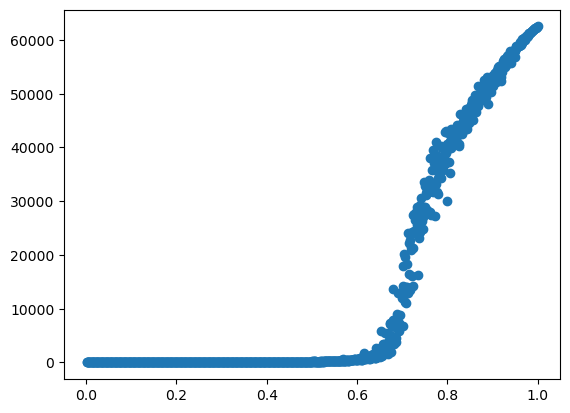

In [72]:
path = r'C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_rgb_img'
files = os.listdir(path)
p_list = []
N_list = []
for file in files:
    p, N = file.split("_")
    p = float(p)
    N = float(N.split('.')[0])
    p_list.append(p)
    N_list.append(N)
    
plt.scatter(p_list,N_list)
    

In [53]:

device = torch.device('cuda')

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
    
def create_cnn(input_size, kernel_size=None,channel_count=None, padding=0, pooling=2):
    if kernel_size is None:
        kernel_size = [5,5,4]
    if channel_count is None:
        channel_count = [1,8,16,32]
        
    layers = []
    size = input_size
    for i in range(len(kernel_size)):
        layers.append(nn.Conv2d(channel_count[i], channel_count[i+1], kernel_size[i],padding=padding))
        layers.append(nn.ReLU())
        # layers.append(LambdaLayer(lambda x: print(x.shape) or x))
        if padding != 'same':
            size -= kernel_size[i] - 1

        if pooling:
            layers.append(nn.MaxPool2d(pooling))
            size = int((size - (pooling - 1) - 1)/pooling + 1)

        
    return nn.Sequential(*layers, 
                        nn.Flatten(), 
                        nn.Linear(size**2*channel_count[-1], 60),
                        nn.ReLU(),
                        nn.Linear(60,1)).to(device)
    

class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, output='p'):
        self.image_list = os.listdir(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.output = output

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        image = read_image(img_path)
        p, N = self.image_list[idx].split("_")
        p = np.float32(p)
        N = np.float32(N.split('.')[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.output == 'p':
            return image, torch.tensor([p])
        return image, torch.tensor([rescale_N(N)])

def rescale_N(N):
    return np.float32(np.log(N)/11)
def undo_rescale_N(N):
    return np.float32(np.exp(N*11))




In [73]:

epochs = 50
sizes = [20,25,30,35,40,45,50,55,60,70,80,90,100,110,120,130]
train_loss = np.zeros((len(sizes), epochs))
test_loss = np.zeros((len(sizes), epochs))

loss_function = torch.nn.MSELoss()

for k, crop_size in enumerate(sizes):
    # if k != 10:
    #     continue
    if k < 5:
        cnn = create_cnn(crop_size, kernel_size=[4,4,3],channel_count=[1,8,16,32], pooling=False)
    else:
        cnn = create_cnn(crop_size, kernel_size=[6,4,3],channel_count=[1,8,16,32])
    optimizer = torch.optim.Adam(cnn.parameters(), lr=2e-4)
    transforms = v2.Compose([
        v2.RandomCrop(crop_size),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
    ])
    dataset = ImageDataset(r"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_image", 
                        transform=transforms, output='N')

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        cnn.train()
        epoch_loss = 0
        for i, data in enumerate(train_dataloader):
            imgs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = cnn(imgs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # print(f'epoch: {epoch+1} loss: {epoch_loss / len(train_dataloader):.3e}')
        train_loss[k, epoch] = epoch_loss/len(train_dataloader)
        
        cnn.eval()
        epoch_loss = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                imgs, labels = data[0].to(device), data[1].to(device)
                outputs = cnn(imgs)
                loss = loss_function(outputs, labels)
                epoch_loss += loss.item()
        test_loss[k, epoch] = epoch_loss/len(test_dataloader)
        print(f'crop_size: {crop_size}  epoch: {epoch+1}  train loss: {train_loss[k, epoch]:.3e}  test loss: {test_loss[k, epoch]:.3e}')
        
    print('Finished Training')


crop_size: 20  epoch: 1  train loss: 2.205e-01  test loss: 8.279e-02
crop_size: 20  epoch: 2  train loss: 4.165e-02  test loss: 2.214e-02
crop_size: 20  epoch: 3  train loss: 1.580e-02  test loss: 1.080e-02
crop_size: 20  epoch: 4  train loss: 9.161e-03  test loss: 7.234e-03
crop_size: 20  epoch: 5  train loss: 7.020e-03  test loss: 6.807e-03
crop_size: 20  epoch: 6  train loss: 7.103e-03  test loss: 6.915e-03
crop_size: 20  epoch: 7  train loss: 7.056e-03  test loss: 7.365e-03
crop_size: 20  epoch: 8  train loss: 6.750e-03  test loss: 6.831e-03
crop_size: 20  epoch: 9  train loss: 6.864e-03  test loss: 6.943e-03
crop_size: 20  epoch: 10  train loss: 6.398e-03  test loss: 7.077e-03
crop_size: 20  epoch: 11  train loss: 5.824e-03  test loss: 5.565e-03
crop_size: 20  epoch: 12  train loss: 5.483e-03  test loss: 5.529e-03
crop_size: 20  epoch: 13  train loss: 5.507e-03  test loss: 5.824e-03
crop_size: 20  epoch: 14  train loss: 5.195e-03  test loss: 6.155e-03
crop_size: 20  epoch: 15  tra

c:\Users\jonat\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


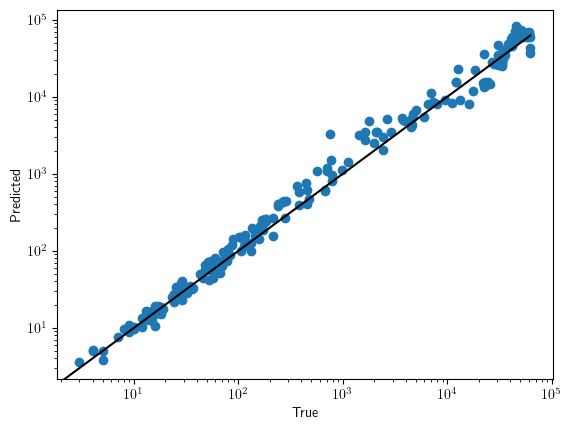

In [82]:
true_value = [] 
pred_value = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        true_value.extend(list(undo_rescale_N(labels.detach().cpu().numpy())))
        pred_value.extend(list(undo_rescale_N(cnn(imgs).detach().cpu().numpy())))
        
plt.scatter(true_value, pred_value)
plt.plot([0,max(true_value)],[0,max(true_value)],c='k')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.xscale('log')
plt.yscale('log')

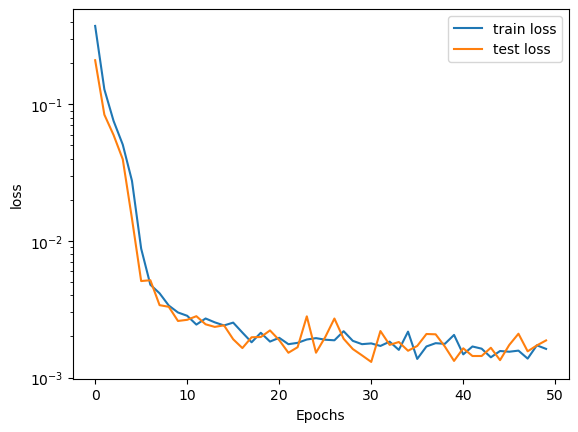

In [42]:
import matplotlib.pyplot as plt
plt.plot(np.arange(epochs), train_loss, label='train loss')
plt.plot(np.arange(epochs), test_loss, label='test loss')
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [336]:
def undo_rescale_N(N):
    return torch.exp(N*10)

y_pred = []
y_true = []
cnn.eval()
epoch_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(imgs)
        y_true.extend(list(undo_rescale_N(labels).detach().cpu().numpy().flatten()))
        print(list(undo_rescale_N(cnn(imgs)).detach().cpu().numpy().flatten()))
        y_pred.extend(list(undo_rescale_N(cnn(imgs)).detach().cpu().numpy().flatten()))


[2396.8413, 476.0644, 267.27277, 59684.645, 62167.47, 58105.273, 263.1834, 65829.09, 77.34641, 7.0112176, 48285.074, 30840.973, 146.50082, 4.274529, 34.41496, 213.12064, 46138.887, 49661.082, 27924.396, 1170.5226, 71.90534, 1557.8586, 329.4449, 7.7590513, 58955.832, 27372.932, 66553.31, 47.057022, 224.3875, 108.877014, 92.03458, 7260.33, 26331.523, 63558.574, 62936.344, 17325.512, 16.518784, 45.646923, 33094.035, 76.18846, 19152.242, 30.668224, 89.4585, 12768.369, 105.32076, 19.148378, 59618.535, 65.215965, 20695.541, 809.2843, 162.56195, 53830.824, 920.1137, 50897.266, 41010.44, 66709.89, 55050.387, 23316.049, 1333.1523, 35.972702, 77.827965, 19.612473, 58287.93, 44656.18]
[3.175574, 137.80399, 56825.4, 65526.754, 10.651172, 70.3758, 78.442154, 126.89681, 46.22485, 51.135757, 49427.715, 12026.479, 136.74638, 5.053612, 66425.734, 34.036255, 40.289608, 39.557747, 211.58922, 34142.727, 31.948606, 260.74063, 1708.9379, 13.8909, 4018.738, 66924.95, 73.300476, 9.500009, 151.24266, 13442.953

Text(0, 0.5, 'Cluster size train loss')

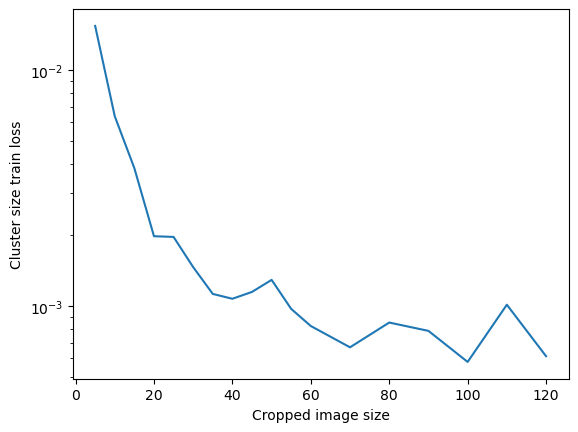

In [28]:
data = np.load(r"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\src\cluster_size_loss.npz")
loss = data['train_loss']
image_size = data['image_sizes']
plt.plot(image_size, np.mean(loss[:,-5:],axis=1))
plt.yscale('log')
plt.xlabel("Cropped image size")
plt.ylabel("Cluster size train loss")

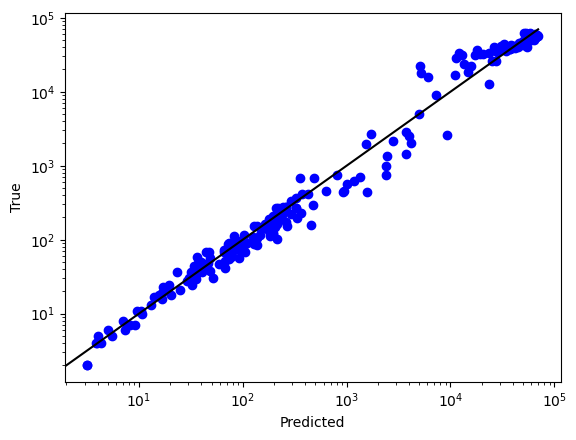

In [344]:
plt.scatter(y_pred,y_true, c='b')
plt.plot([0,max(y_pred)],[0,max(y_pred)],c='k')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.yscale('log')
plt.xscale('log')

# Training on rgb data

In [57]:

epochs = 50
sizes = [20,25,30,35,40,45,50,55,60,70,80,90,100,110,120,130]
train_loss2 = np.zeros((len(sizes), epochs))
test_loss2 = np.zeros((len(sizes), epochs))

loss_function = torch.nn.MSELoss()

for k, crop_size in enumerate(sizes):
    if k < 5:
        continue
    if k < 5:
        cnn = create_cnn(crop_size, kernel_size=[4,4,3],channel_count=[3,8,16,32], pooling=False)
    else:
        cnn = create_cnn(crop_size, kernel_size=[6,4,3],channel_count=[3,8,16,32])
    optimizer = torch.optim.Adam(cnn.parameters(), lr=4e-4)
    transforms = v2.Compose([
        v2.RandomCrop(crop_size),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
    ])
    dataset = ImageDataset(r"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_rgb_img", 
                        transform=transforms, output='N')

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        cnn.train()
        epoch_loss = 0
        for i, data in enumerate(train_dataloader):
            imgs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = cnn(imgs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # print(f'epoch: {epoch+1} loss: {epoch_loss / len(train_dataloader):.3e}')
        train_loss2[k, epoch] = epoch_loss/len(train_dataloader)
        
        cnn.eval()
        epoch_loss = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                imgs, labels = data[0].to(device), data[1].to(device)
                outputs = cnn(imgs)
                loss = loss_function(outputs, labels)
                epoch_loss += loss.item()
        test_loss2[k, epoch] = epoch_loss/len(test_dataloader)
        print(f'crop_size: {crop_size}  epoch: {epoch+1}  train loss: {train_loss2[k, epoch]:.3e}  test loss: {test_loss2[k, epoch]:.3e}')
        
    print('Finished Training')


crop_size: 45  epoch: 1  train loss: 2.858e-01  test loss: 1.902e-01
crop_size: 45  epoch: 2  train loss: 1.527e-01  test loss: 1.069e-01
crop_size: 45  epoch: 3  train loss: 5.151e-02  test loss: 1.653e-02
crop_size: 45  epoch: 4  train loss: 6.308e-03  test loss: 5.935e-03
crop_size: 45  epoch: 5  train loss: 4.822e-03  test loss: 3.150e-03
crop_size: 45  epoch: 6  train loss: 2.652e-03  test loss: 2.299e-03
crop_size: 45  epoch: 7  train loss: 2.491e-03  test loss: 2.294e-03
crop_size: 45  epoch: 8  train loss: 2.412e-03  test loss: 2.227e-03
crop_size: 45  epoch: 9  train loss: 2.246e-03  test loss: 1.694e-03
crop_size: 45  epoch: 10  train loss: 2.207e-03  test loss: 2.632e-03
crop_size: 45  epoch: 11  train loss: 2.106e-03  test loss: 1.847e-03
crop_size: 45  epoch: 12  train loss: 1.854e-03  test loss: 1.289e-03
crop_size: 45  epoch: 13  train loss: 1.591e-03  test loss: 1.584e-03
crop_size: 45  epoch: 14  train loss: 1.688e-03  test loss: 2.462e-03
crop_size: 45  epoch: 15  tra

KeyboardInterrupt: 

In [55]:
path = r"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_rgb_img"
files = os.listdir(path)
for file in files:
    if '(' in file:
        os.remove(os.path.join(path, file))